In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

from subprocess import check_output

# Any results you write to the current directory are saved as output.
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

In [2]:
data = pd.read_csv('full_data_new.csv')

In [3]:
data['convert_to_date'] = pd.to_datetime(data['Date'])

In [4]:
data['Day'] = data['convert_to_date'].dt.day
data['Month'] = data['convert_to_date'].dt.month
data['Year'] = data['convert_to_date'].dt.year

In [7]:
data.to_csv('full_data_with_dates.csv')

In [18]:
small_data = data[['Day','Month', 'Year', 'Date', 'Latitude', 'Longitude']]

In [22]:
factor_lat = 0.00898892564 # KMs in 1 degree lat
factor_lon = 0.01424562303 # KMs in 1 degree lon

In [30]:
lat_max = 51.538700 + 4*factor_lat
lat_min = 51.538700 - 4*factor_lat
lon_min = 0.016600 - 4*factor_lon
lon_max = 0.016600 + 4*factor_lon

In [31]:
london = small_data.loc[(small_data['Latitude'] < lat_max)&
                          (small_data['Latitude'] > lat_min)&
                          (small_data['Longitude'] < lon_max)&
                          (small_data['Longitude'] > lon_min)]

In [32]:
olympics = london[((london['Month']==7)|(london['Month']==8))&
                        (london['Year']==2012)]

In [33]:
others = london[~london.isin(olympics)].dropna()

In [34]:
olympics_dist = list(olympics.groupby(['Date']).count().Day)
others_dist = list(others.groupby(['Date']).count().Day)

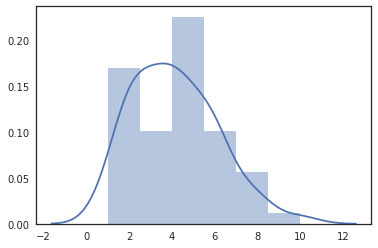

In [35]:
sns.distplot(olympics_dist)

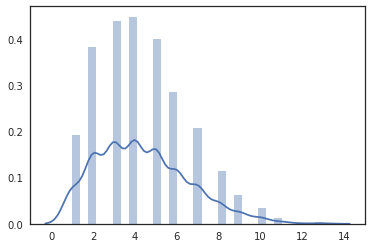

In [36]:
sns.distplot(others_dist)